# Introdução 

Esse notebook tem o objetivo de implementar o TSMOM do  Moskowitz. Estratégia baseada no paper: [Time Series Momentum](http://docs.lhpedersen.com/TimeSeriesMomentum.pdf) by Tobias J. Moskowitza, Yao Hua Ooi and Lasse Heje Pedersen.

Artigo no medium: [Construindo uma Estratégia de Investimentos Quantitativa — Time Series Momentum](https://medium.com/turing-talks/construindo-uma-estrat%C3%A9gia-de-investimentos-quantitativa-time-series-momentum-7e60a40636bd)


Estratégia implementada por: [Lucas Leme Santos](https://www.linkedin.com/in/lucas-leme-santos/)

# Importação

## Bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time

## Dados


In [2]:
def import_data(csv): 
    
    df = pd.read_csv(csv)
    df.index = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df = df.drop('date', axis=1)
    
    close_columns = []
    high_columns = []
    low_columns = []
    open_columns = []
    volume_columns = []
    open_int_columns = []

    for i in df.columns:
        if "close" in i:
            close_columns.append(i)
        elif "high" in i:
            high_columns.append(i)
        elif "low" in i:
            low_columns.append(i)
        elif "open_int" in i:
            open_int_columns.append(i)
        elif "open" in i:
            open_columns.append(i)
        elif "volume" in i:
            volume_columns.append(i)

    close_df = df[close_columns]
    high_df = df[high_columns]
    low_df = df[low_columns]
    open_df = df[open_columns]
    volume_df = df[volume_columns]
    open_int_df = df[open_int_columns]
    
    return [close_df, high_df, low_df, open_df, volume_df, open_int_df]

In [3]:
close_df, high_df, low_df, open_df, volume_df, open_int_df = import_data("data.csv")

close_df.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-21,42.81,143.90,2468.0,67.537,220.54,20.06,112.848,88.1480,3054.57,1464.26,...,72.14,4614.72,163.364,75.10,11237.36,5618.6,16474.0,1464.92,82.26,7704.9
1999-06-22,43.12,143.72,2421.0,67.537,222.69,20.20,113.002,88.1247,2984.70,1452.69,...,71.50,4536.94,166.007,74.87,11138.79,5586.4,16387.0,1453.39,82.11,7702.8
1999-06-23,43.39,142.89,2304.0,67.507,220.19,20.26,113.057,88.1060,3006.66,1445.15,...,74.32,4558.54,165.846,74.47,11119.07,5536.9,16262.0,1445.85,81.88,7601.4
1999-06-24,43.42,143.63,2227.0,67.497,222.81,20.29,112.419,88.0781,2952.09,1434.93,...,73.67,4528.30,162.323,73.86,10914.04,5466.2,16225.0,1435.62,81.59,7486.8
1999-06-25,43.64,143.52,2221.0,67.824,221.30,20.42,112.144,88.0781,2948.10,1430.89,...,74.08,4562.87,162.963,74.17,10921.93,5478.0,16229.0,1431.52,81.66,7511.3


## Visualização dos dados

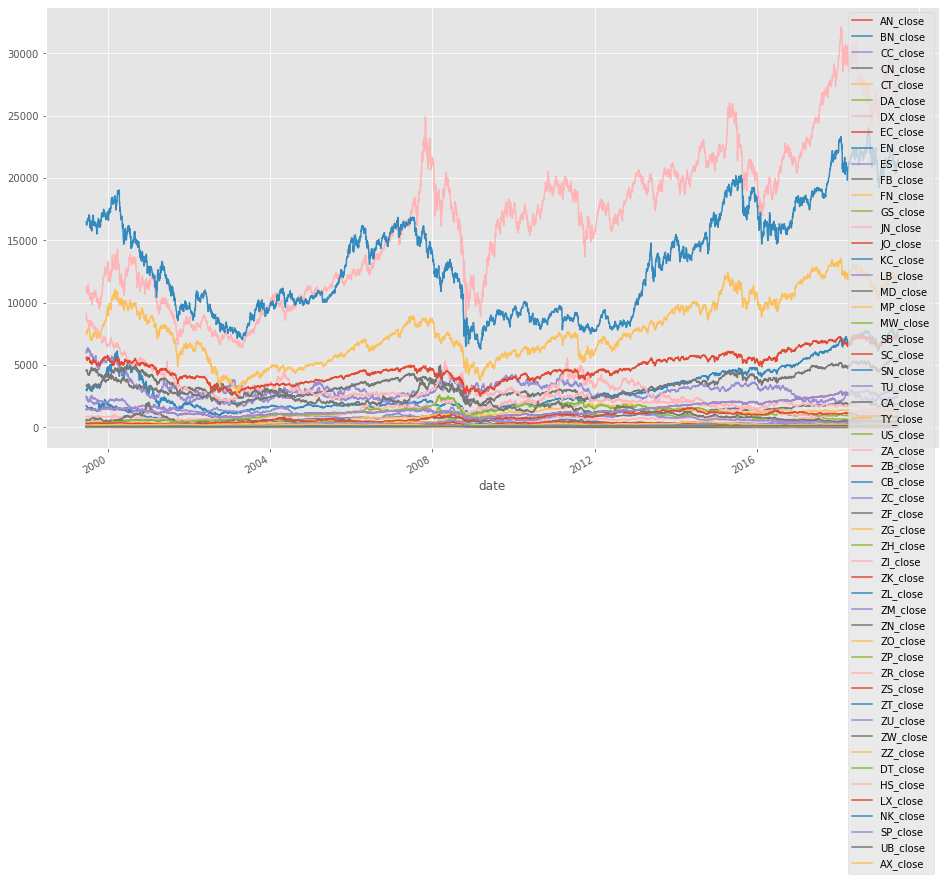

In [4]:
close_df.plot(figsize=(16,9))

# Retornos

$r_t = \frac{p_t - p_{t-1}}{p_{t-1}}$

A formula acima compõe o que chamamos de retorno de um ativo, sendo o parâmetro k o período ao qual desejamos avaliar o retorno, podendo ser diário, semanal, mensal, etc.
Que posteriormente iremos extrair o momentum a partir da equação do retorno apresentada, já que o retorno armazena tanto informação de intensidade de aumento ou decréscimo, quanto de tendência positiva ou negativa. Assim, podemos avaliar o momentum de 12 meses, tomando um período mensal e fazendo k = 12.

In [5]:
# Retornos diários
returns_daily = close_df.pct_change().fillna(0)

# Retornos mensais
returns_monthly = close_df.pct_change(20).fillna(0).resample('BM').last().ffill()

In [6]:
returns_monthly.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1999-07-30,-0.021189,0.027540,-0.036536,-0.026502,-0.023546,0.225436,-0.029160,-0.000898,-0.021701,-0.036184,...,0.057915,-0.001894,0.109267,-0.018399,-0.021324,-0.016784,-0.007313,-0.036115,-0.010875,-0.049923
1999-08-31,-0.018156,-0.009752,-0.088951,0.007060,-0.044586,-0.046805,0.003214,-0.001936,0.051176,-0.009011,...,0.072384,0.006645,0.056515,-0.005199,0.022540,-0.001041,-0.005709,-0.009013,-0.001482,0.033014
1999-09-30,0.019440,0.023623,0.082220,0.017450,0.035829,-0.052946,-0.012567,0.000425,0.006367,-0.027313,...,0.109586,-0.023030,0.044980,-0.007839,-0.067142,-0.033892,-0.001976,-0.027490,-0.001608,-0.031337
1999-10-29,-0.032102,-0.003557,-0.169066,-0.007434,-0.031499,-0.104911,0.000806,-0.000586,0.076889,0.063359,...,-0.106911,-0.104987,-0.001076,0.000416,0.028891,0.040530,0.041638,0.063277,-0.004831,0.076805


## Volume

Calculando o volume mensal de transações para cada ativo

In [7]:
def monthly_volume_f(volume, period=20):
    
    daily_volume = volume.copy()
    
    for row in range(period, len(volume)):
        daily_volume.iloc[row] = volume.iloc[row-period:row,:].cumsum().iloc[-1]
        
    monthly_volume = daily_volume.resample("BM").last().ffill()
    
    return monthly_volume

In [8]:
monthly_volume_df = monthly_volume_f(volume_df)
monthly_volume_df.head()

,AN_volume,BN_volume,CC_volume,CN_volume,CT_volume,DA_volume,DX_volume,EC_volume,EN_volume,ES_volume,...,ZU_volume,ZW_volume,ZZ_volume,DT_volume,HS_volume,LX_volume,NK_volume,SP_volume,UB_volume,AX_volume
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,5105.0,5437.0,8479.0,19468.0,7403.0,95.0,897.0,665583.0,2785.0,36762.0,...,215545.0,40707.0,17210.0,548656.0,16181.0,37293.0,1713.0,113634.0,213879.0,36480.0
1999-07-30,75098.0,232169.0,122423.0,203581.0,171719.0,3691.0,26001.0,7329080.0,59660.0,840782.0,...,3406732.0,505325.0,232688.0,13324714.0,422846.0,594574.0,29451.0,1609160.0,4991001.0,837323.0
1999-08-31,48349.0,166114.0,138166.0,169856.0,161377.0,6191.0,19849.0,7929949.0,75295.0,952811.0,...,3031274.0,530234.0,154380.0,10585832.0,368204.0,548925.0,31238.0,1849454.0,4496537.0,876839.0
1999-09-30,107051.0,277841.0,142654.0,256202.0,170315.0,1826.0,29047.0,7249942.0,87626.0,1084734.0,...,3235681.0,518888.0,184417.0,12084688.0,345919.0,1006549.0,71558.0,2796161.0,5229991.0,1176503.0
1999-10-29,51211.0,178635.0,153762.0,156492.0,182146.0,2709.0,27186.0,7041099.0,105146.0,1217055.0,...,3364142.0,434448.0,189878.0,11762818.0,349599.0,654932.0,29858.0,1996404.0,5231698.0,967257.0


# Volatilidades

Um conceito frequentemente associado ao risco de um ativo é a volatilidade. Pois como o risco precisa ser mensurado, a volatilidade acaba sendo uma das formas mais simples de mensurar o risco. A partir dos dados histórico de uma série temporal, podemos utilizar uma medida descritiva estatística chamada desvio padrão para determinar a variação dos dados entorno de sua média histórica.

Um valor baixo de volatilidade indica uma estabilidade no investimento. Já uma alta volatilidade indica incerteza, porém com um potencial de lucro maior, se o investidor estiver disposto a suportar o risco. Além do desvio padrão, existem diversas outras maneiras de estimar risco:

- EWMA: Exponential weighted moving average, volatilidade com maior pesos nos dias mais recentes, no caso 60 dias
- Parkinson number: Estimativa de vol com preços de alta e baixa
- Garman-Klass: Estimativa de vol com preço: alta, baixa, abertura e fechamento.

## EWMA

Um estimador um pouco mais complexo é advindo do modelo de médias móveis, o exponentially weighted moving average. Esse estimador basicamente calcula o desvio padrão com um peso ponderado maior para os dados mais recentes. Essa característica é muito importante, pois em longos períodos a séries temporal pode perder a estacionalidade, o que prejudica nosso modelo se considerarmos valores muito distantes.

In [9]:
# Vol diária
vol_daily = returns_daily.ewm(adjust=True, com=60, min_periods=0).std().dropna()

# Vol de 261 dias, apenas o último dia de cada mês
vol_monthly = (np.sqrt(261)*vol_daily).resample('BM').last().ffill()

In [10]:
vol_monthly.head()

,AN_close,BN_close,CC_close,CN_close,CT_close,DA_close,DX_close,EC_close,EN_close,ES_close,...,ZU_close,ZW_close,ZZ_close,DT_close,HS_close,LX_close,NK_close,SP_close,UB_close,AX_close
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,0.099657,0.058628,0.326745,0.074062,0.194569,0.109147,0.053404,0.006329,0.254981,0.159787,...,0.355438,0.135659,0.368062,0.068701,0.205930,0.084750,0.091042,0.159730,0.030139,0.118389
1999-07-30,0.100956,0.090961,0.362069,0.052317,0.244505,0.225781,0.071222,0.004359,0.268479,0.149467,...,0.297552,0.278549,0.407706,0.072081,0.306736,0.220881,0.185948,0.149252,0.040948,0.215890
1999-08-31,0.100265,0.086400,0.315477,0.065318,0.231420,0.260459,0.081524,0.005153,0.281176,0.172133,...,0.288673,0.253385,0.380643,0.071235,0.311757,0.219495,0.190226,0.171941,0.040428,0.220648
1999-09-30,0.098584,0.082446,0.350053,0.060984,0.228155,0.269823,0.079807,0.005873,0.293490,0.185291,...,0.269880,0.259462,0.351287,0.074840,0.292105,0.208371,0.183706,0.185418,0.043175,0.215401
1999-10-29,0.101519,0.082757,0.328539,0.055669,0.217601,0.296536,0.086697,0.006815,0.308028,0.216552,...,0.376301,0.246463,0.350727,0.075301,0.328296,0.212098,0.189295,0.216482,0.043146,0.212663


### Parkinson number

O Número de Parkinson foi desenvolvido pelo físico Michael Parkinson em 1980 e tem como objetivo estimar a volatilidade de uma série temporal a partir dos preços de High e Low. A principal vantagem em relação ao EWMA é a adição de variação intra diária, pois no cálculo leva-se em conta os valores de alta e baixa dos preços.

![Número de Parkinson](images/parkinson_vol.png)

Para calcular essa estimativa são necessários dois parâmetros N e n. Sendo N um fator de escala dos períodos, se for necessário um desvio padrão diário atribui-se N = 1, já para o desvio padrão anual N = 365. O segundo parâmetro n é o tamanho da amostra de dados passados que serão utilizados no modelo. Escolhido n realiza-se o somatório dos n períodos passados, da seguinte operação: logaritmo da divisão do preço de alta e baixa dos n períodos, e por fim eleva-se ao quadrado para realizar a soma.

In [11]:
def parkinson_vol(high_df, low_df, period=60):
    """
    Estimando a volatilidade a partir dos preço de Alta e de Baixa
    """
    
    # Calculando parcela interna da somatoria
    x = np.log(np.divide(high_df, low_df)) ** 2
    x.columns = [x[0:3] + "pv" for x in x.columns]
    
    # Criando dataframe para atribuir as volatilidades
    pv = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1 / (4 * period * np.log(2))
    
    # Atribuindo not a number, para os valores iniciais
    pv.iloc[:period,:] = np.nan
        
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        pv.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return pv

In [12]:
pv_df = parkinson_vol(high_df, low_df)
pv_monthly = (np.sqrt(261)*pv_df).resample('BM').last().ffill()

pv_monthly.head()

,AN_pv,BN_pv,CC_pv,CN_pv,CT_pv,DA_pv,DX_pv,EC_pv,EN_pv,ES_pv,...,ZU_pv,ZW_pv,ZZ_pv,DT_pv,HS_pv,LX_pv,NK_pv,SP_pv,UB_pv,AX_pv
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-09-30,0.099552,0.080792,0.315857,0.050618,0.202873,0.243479,0.061908,0.005640,0.279054,0.172749,...,0.235561,0.215090,0.335145,0.069490,0.163150,0.180401,0.084729,0.147775,0.039878,0.175627
1999-10-29,0.094599,0.079470,0.310301,0.047501,0.187113,0.259965,0.061020,0.005203,0.295026,0.194137,...,0.241094,0.217622,0.296288,0.063695,0.163058,0.184440,0.086341,0.161423,0.037080,0.180752


## Garman and Klass volatility

Garman é uma extensão do número de parkinson, porém agora com a inserção de mais dados no modelo, que são preços de abertura e fechamento do dia. Esses dados ajudam a aumentar a precisão do estimador, principalmente em ativos com maior estresse em momentos de abertura e fechamento. O cálculo é similar ao estimador anterior, segue abaixo a equação:

![Garman Klass vol](images/garman-klass_vol.png)

In [13]:
def garman_klass_vol(high_df, low_df, close_df, open_df, period=60):
    """
    Estima a volatilidade a partir dos seguintes preços: alta, baixa, abertura e fechamento
    """
    # Calculando parcelas internas da somatoria
    x_hl = (1/2)*(np.log(np.divide(high_df, low_df))) ** 2
    x_co = - (2 * np.log(2) - 1)* (np.log(np.divide(close_df, open_df))**2)
    
    # Somando parcelas calculadas
    x = x_hl + x_co.values
    
    # Criando dataframe para atribuir as volatilidades
    gk = x.copy()
    
    # Termo constante fora da somatoria (Considerando vol diaria)
    const = 1/period
    
    # Atribuindo not a number, para os valores iniciais
    gk.iloc[:period,:] = np.nan
    
    # iteração do centro de massa da vol
    for row in range(period, len(high_df)):
        gk.iloc[row] = np.sqrt(const * np.sum(x.iloc[row-period:row,:]))
        
    return gk

In [14]:
gk_df = garman_klass_vol(high_df, low_df, close_df, open_df)
gk_monthly = (np.sqrt(261)*gk_df).resample('BM').last().ffill()

gk_monthly.head()

,AN_high,BN_high,CC_high,CN_high,CT_high,DA_high,DX_high,EC_high,EN_high,ES_high,...,ZU_high,ZW_high,ZZ_high,DT_high,HS_high,LX_high,NK_high,SP_high,UB_high,AX_high
date,,,,,,,,,,,,,,,,,,,,,
1999-06-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-07-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-08-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-09-30,0.097246,0.079514,0.313968,0.053086,0.204841,0.242893,0.062291,0.005631,0.273707,0.172755,...,0.236265,0.211568,0.343169,0.070644,0.145004,0.180593,0.087065,0.149394,0.039906,0.172406
1999-10-29,0.093327,0.078885,0.307924,0.049376,0.186758,0.263382,0.061887,0.005098,0.292936,0.189013,...,0.244624,0.210796,0.299139,0.063714,0.144744,0.182661,0.088807,0.161436,0.036958,0.174152


## Visualização das volatilidades

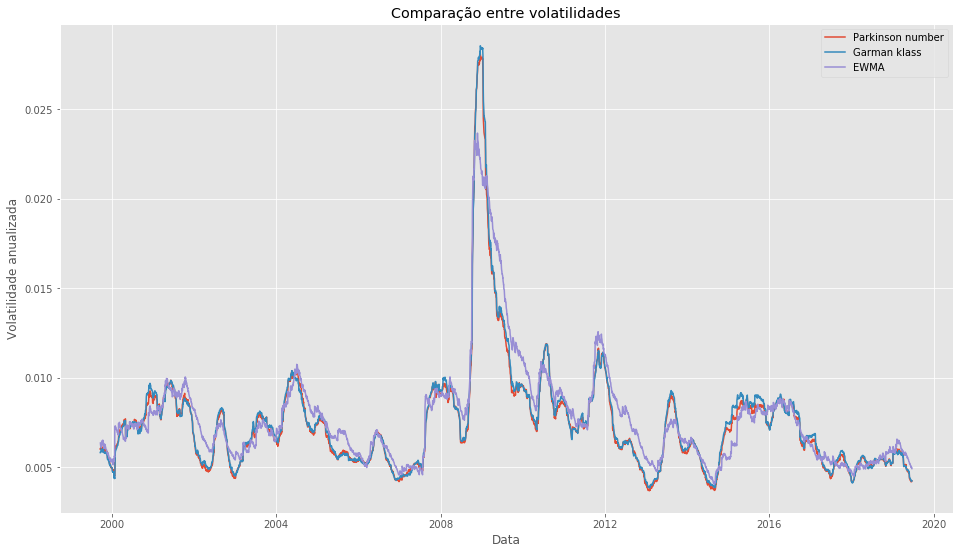

In [15]:
plt.figure(figsize=(16,9))

# Ativo que será plotada a comparação
asset = 0

plt.plot(pv_df.iloc[:,asset], label= "Parkinson number")
plt.plot(gk_df.iloc[:,asset], label="Garman klass")
plt.plot(vol_daily.iloc[60:,asset], label="EWMA")

plt.title("Comparação entre volatilidades")
plt.xlabel("Data")
plt.ylabel("Volatilidade anualizada")

plt.legend()
plt.show()

Para efeito de comparação construímos o gráfico das 3 volatilidades em um preço de contrato futuro. Podemos perceber que, principalmente em momentos de maior estresse, os modelos Parkinson e Garman Klass têm uma resposta mais rápida e mais precisa. Um período que pode-se destacar é o ano de 2008, que os dois modelos acabaram captando mais informações intra diárias da crise da bolha hipotecária.

In [16]:
def response (x):
    
    return (x * np.exp((-x ** 2) / 4)) / 0.89

def HL (n):
    
    return np.log(0.5) / np.log(1 - 1/n)

def momentum_cta(returns, sk, lk):
    
    sets = len(sk)
    
    signals = []
    
    for k in range(sets):
        
        xk = returns.ewm(halflife = HL(sk[k])).mean() - returns.ewm(halflife = HL(lk[k])).mean()
        
        yk = xk / returns.rolling(63).std()
        
        zk = yk / returns.rolling(252).std()
        
        uk = response(zk)
        
        signals.append(uk)
        
    cta = pd.DataFrame(signals).mean()
        
    return cta

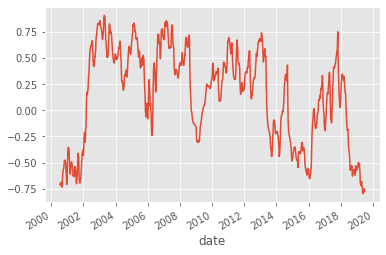

In [17]:
momentum_cta(close_df.iloc[:,0], np.array([16, 32, 64]), np.array([48, 96, 192])).plot()

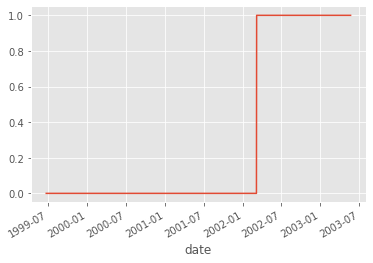

In [18]:
((momentum_cta(close_df.iloc[:900,0], np.array([16, 32, 64]), np.array([48, 96, 192])) > 0).astype(int)).plot()

## Estratégia

![Equação do TSMOM](images/tsmom_eq.jpeg)

Em resumo a equação final do TSMOM do Moskowitz pode ser dividida nos seguintes tópicos: 
- Posição
- Alocação
- Retorno do portfólio

#### Posição

Para determinar a posição de compra ou venda de um ativo, é necessário algum sinal de previsão, neste caso é utilizado o momentum (retorno) de 12 meses. Com o sinal em mãos classifica-se a posição a partir da direção do momentum.

#### Alocação

Quando se trata de alocação de portfólio no mundo quantitativo, existem diversas ferramentas, tais como: matrizes de covariâncias, autovalores, autovetores, PCA, autoencoders e entre outros. Mas para simplificar nosso modelo, iremos controlar as alocações para que elas estejam, em média, entorno de uma meta de risco. Definiremos o desvio padrão anual médio da carteira como meta, pois estamos dispostos a ter um risco médio de um contrato futuro, que no caso dos nossos dados é de 40%.
Para o risco estimado, podemos utilizar as volatilidades discutidas nos tópicos anteriores. Com os dois parâmetros necessários (risco estimado e risco médio), temos uma razão que é inversamente proporcional ao risco de um ativo, ou seja, ativos muito voláteis acabam tendo uma alocação menor, e o contrário ocorre para ativos com baixo risco, que têm uma maior parcela na carteira.
Vale ressaltar que ambos os casos tendem a se normalizar para o risco do portfólio (40%). Por exemplo: um ativo com 20% de volatilidade, o cálculo da alocação seria o seguinte: 40%/20% = 2, ou seja, esse ativo teria um alavancagem de 2 vezes, o que dobraria seu risco.

#### Retorno do portfólio

Por fim, temos o número que realmente importa, o rendimento total do investimento. Podemos calculá-lo no fim do período, com os retornos de cada ativo. Graças a simplificação de alocação, podemos calcular a média do retorno de todos ativos (St), esse será o retorno do portfólio, conforme a imagem acima.

In [19]:
# Importando algoritmos de machine learning
from sklearn.linear_model import LinearRegression
from sklearn.tree         import DecisionTreeRegressor
from sklearn.ensemble     import RandomForestRegressor
from sklearn import svm

# Classification ML Algorithms
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

# Funções de backtesting e visualização

In [20]:
def get_feature_target(parameters, stock, date):
    
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = parameters
    
    train = pd.DataFrame()

    train["Returns Monthly"] = returns_monthly.iloc[:,stock]
    train["EWMA"] = vol_monthly.iloc[:,stock]
    train["Parkinson"] = pv_monthly.iloc[:,stock]
    train["Garman-Klass"] = gk_monthly.iloc[:,stock]
    train["Monthly Volume"] = monthly_volume_df.iloc[:,stock]
    train["Momentum CTA"] = momentum_cta(close_df.iloc[:,stock], np.array([16, 32, 64]), np.array([48, 96, 192])).resample("BM").last().ffill()

    prices = close_df.iloc[:,stock]

    for lag in [3, 6, 9, 12]:
        train["Momentum " + str(lag)] = prices.pct_change(lag * 21)

    target = train["Returns Monthly"].shift(-1)
    
    features = train.dropna()
    target = target.dropna()
    
    return (features.iloc[:date], target.iloc[:date], features.iloc[date])

def ml_signal(model, parameters, date):
    """
    Função que constroí o vetor de posições (long ou short), utilizando machine learning
    """
    signal = []

    for stock in range(54):

        features, target, X_test = get_feature_target(parameters, stock, date)
            
        # **TRAIN DATA**
        # Features
        X = features

        # Target
        y = np.sign(target)

        # Fitting the model
        model.fit(X, y)
        
        pred = model.predict([X_test])
        signal.append(pred[0])
        
    return signal

def signal(parameters, date, passive, method="momentum"):
    """
    Função que constrói o sinal para diversos metodos, sendo o tradicional: momentum
    """
    
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = parameters
    
    df = close_df
        
    num_assets = len(df.iloc[-1])
    signal = []
    
    if passive:
        signal = np.ones(num_assets)
    else:
    
        if method == "momentum":

            returns = df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            signal = np.where(returns.iloc[-1] > 0, 1, -1)

        elif method == "momentum_lagged":

            returns_12 = df.pct_change(21 * 12).resample('BM').last().ffill()[:date]

            returns_6 = df.pct_change(21 * 6).resample('BM').last().ffill()[:date]

            returns_3 = df.pct_change(21 * 3).resample('BM').last().ffill()[:date]

            momentum_mean = (returns_12.iloc[-1] + returns_6.iloc[-1] + returns_3.iloc[-1]) / 3

            signal = np.where(momentum_mean > 0, 1, -1)
            
        elif method == "svc":

            signal = ml_signal(SVC(), parameters, date-1)
            
        elif method == "mlpc":

            signal = ml_signal(MLPClassifier(solver='lbfgs', 
                          alpha=1e-3, 
                          activation='relu',
                          hidden_layer_sizes=(5, 3), 
                          random_state=1), parameters, date-1)
            
        elif method == "random_forest":
            signal = ml_signal(RandomForestClassifier(), parameters, date-1)
            
        elif method == "monkey":
        
            signal =  (np.random.randn(num_assets) < 0.5).astype(int)
            
        elif method == "momentum_cta":
            si = []
            for asset in close_df.columns:
                cta = (momentum_cta(close_df[asset], np.array([16, 32, 64]), np.array([48, 96, 192]))).resample('BM').last().ffill()[:date][-1]
                si.append(cta)
               
            signal = si
                
    return signal
    
def tsmom (paramters, date, vol="ewma", method = 'momentum', risk=0.4, passive=False, momentum_window=12):
    """
    Simula a estrátegia de investimento em um período, retorna a rentabilidade no período simulado.
    """
    returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, ewma_vol, pv_monthly, gk_monthly = paramters
    
    vol_monthly = []
    
    if vol == "ewma":
        vol_monthly = ewma_vol
    elif vol == "parkinson":
        vol_monthly = pv_monthly
    elif vol == "garman_klass":
        vol_monthly = gk_monthly
    else:
        raise NameError('Volatilidade invalida')
    
    position = signal(parameters, date, passive, method)
        
    weights = (risk / vol_monthly.iloc[date-1])
    
    weights /= len(weights)
    
    portfolio = position * weights
    
    month_return = 1+np.dot(portfolio, returns_monthly.iloc[date])
    
    return (month_return)



In [24]:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Barra de progresso
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()

def plot_backtesting(returns_model, returns_baseline, years, label_model, label_baseline, title):

    plt.figure(figsize=(16, 9))

    plt.plot(100*returns_model.cumprod(), label=label_model, color='blue')
    plt.plot(100*returns_baseline.cumprod(),
             label=label_baseline, color='red')

    plt.yscale('log')
    plt.legend()
    plt.title(title)
    plt.show()
    
    passive_return = float((returns_baseline.cumprod().iloc[-1] - 1)*100)
    tsmom_return = float((returns_model.cumprod().iloc[-1] - 1)*100)
    
    r = returns_model - 1 
    rp = returns_baseline - 1
    
    # Sharpe
    sharpe_r = np.sqrt(12) * r.mean()/r.std()
    sharpe_rp = np.sqrt(12) * rp.mean() / rp.std()
    
    # Beta
    beta_matrix = pd.concat([r, rp], axis =1)

    beta = beta_matrix.cov().iloc[0,1]/ rp.std()

    print('Passive ', label_baseline, ' return: ', round(passive_return,2), '%,',
         " Annualized: ", round((((100+passive_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')

    print('TSMOM ', label_model, ' return: ', round(tsmom_return,2), "%,",
         " Annualized: ", round((((100+tsmom_return)/100) ** (1/years) - 1)*100 , 2), "%", sep='')
    print("Sharpe ratio Model: ", sharpe_r[0] )
    print("Sharpe ratio Long Only: ", sharpe_rp[0])
    print("Beta: ", beta[0])
    
def backtesting(parameters, vol, start_date, years, method, risk=0.4, plot=True):
    """
    Função que realiza o backtesting do algoritmo
    """
    start_time = time.time()
    
    returns_model = []  
    returns_baseline = []
    sharpe = []
    
    start = start_date
    years = years
    end = 12*(int(start/12) + years)


    for i in range(start, end):
        
        printProgressBar (iteration=i-start, total=end-start-1)
        
        returns_model.append(tsmom(parameters, i, vol, method, risk))

        returns_baseline.append(tsmom(parameters, i, vol, risk, passive=True))

    returns_model = pd.DataFrame(returns_model)
    returns_baseline = pd.DataFrame(returns_baseline)

    returns_model.index = returns_monthly.iloc[start:end].index
    returns_baseline.index = returns_monthly.iloc[start:end].index

    if plot:
        plot_backtesting(returns_model, returns_baseline, years, method, "Long only", "Cumulative returns")

    print("Tempo: %s segundos" % (time.time() - start_time))
        
    return [returns_model, returns_baseline]

# Backtesting

## Momentum com EWMA como estimador de risco
Implementação Clássica do paper do Moskowitz

In [25]:
parameters = (returns_monthly, returns_daily, close_df, high_df, low_df, open_df, volume_df, monthly_volume_df, open_int_df, vol_monthly, pv_monthly, gk_monthly )

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


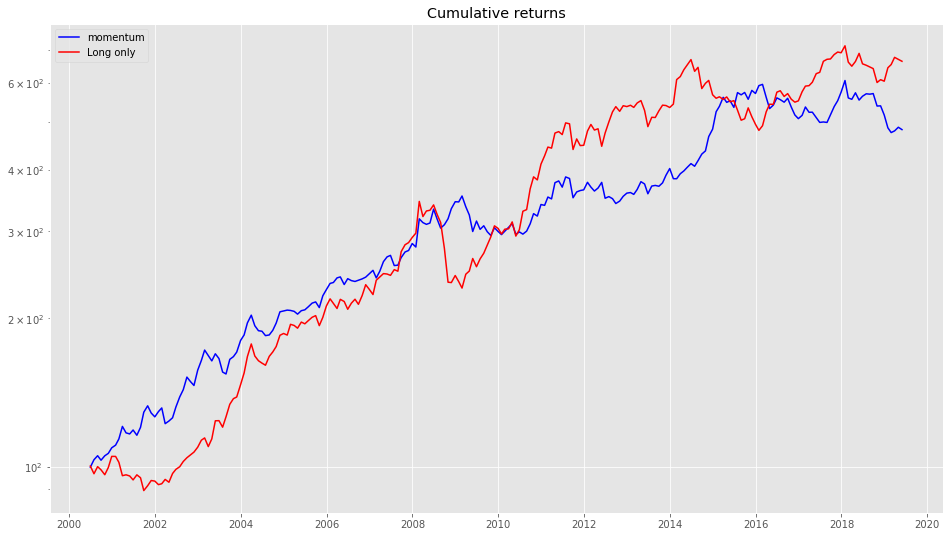

Passive Long only return: 563.65%, Annualized: 10.47%
TSMOM momentum return: 382.36%, Annualized: 8.63%
Sharpe ratio Model:  0.7753828136703583
Sharpe ratio Long Only:  0.7894018271213199
Beta:  0.006853555149182106
Tempo: 2.994555950164795 segundos


In [26]:
r_cl, rp_cl = backtesting(parameters, vol="ewma", start_date = 12, years=19,risk=0.4, method="momentum", plot=True);

E aqui finalmente temos os resultados do TSMOM. Ao total, obtemos 382.36% na estratégia original e 563.65% na long only. Que anualizando os retornos temos respectivamente 8.63% e 10.47%. Apesar de, no longo prazo, o TSMOM não superar o seu índice (Long only), é importante ressaltar a performance entre os anos 2000 e 2009. Período no qual ocorreram duas importante crises: bolha da internet (“dot-com”) e bolha hipotecária.

## Momentum Com  Parkinson como estimador

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


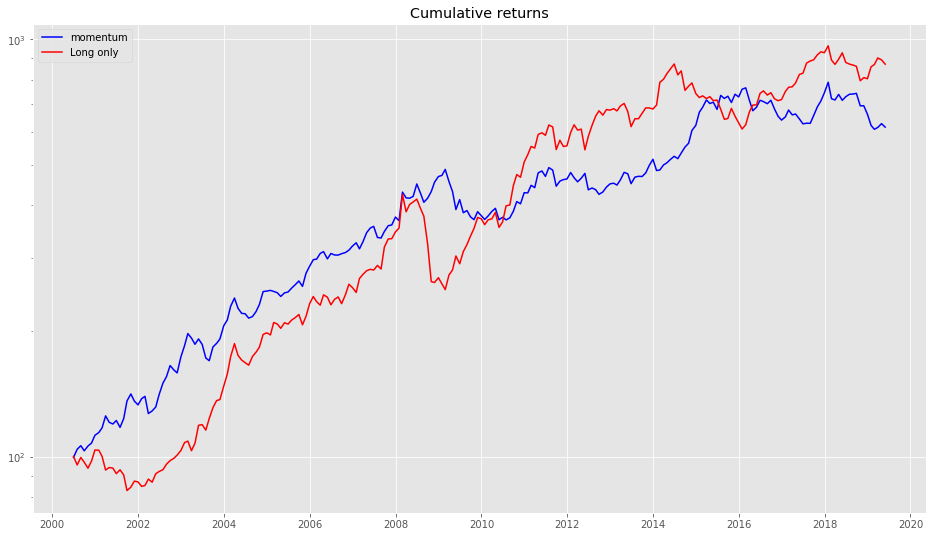

Passive Long only return: 771.56%, Annualized: 12.07%
TSMOM momentum return: 516.08%, Annualized: 10.04%
Sharpe ratio Model:  0.7714308185964853
Sharpe ratio Long Only:  0.7763354358909687
Beta:  0.007337766936360749
Tempo: 3.0790889263153076 segundos


In [27]:
r_cl_pk, rp_cl_pk = backtesting(parameters, vol="parkinson", start_date = 12, years=19, risk = 0.4, method="momentum", plot=True);

## Momentum com Garman Klass como estimador

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


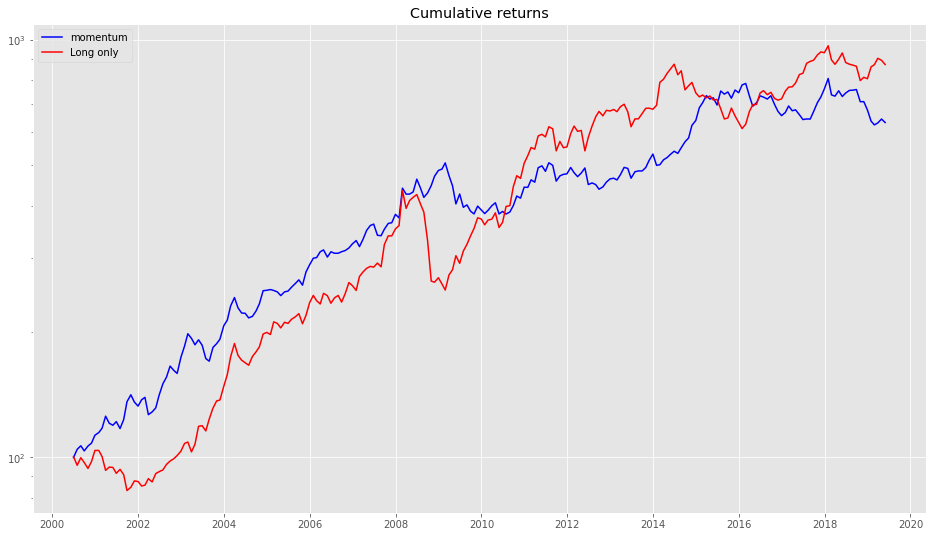

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum return: 533.62%, Annualized: 10.21%
Sharpe ratio Model:  0.7787711130879245
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.007209869559824512
Tempo: 2.9443111419677734 segundos


In [28]:
r_cl_gk, rp_cl_gk = backtesting(parameters, vol="garman_klass", start_date= 12, years=19,risk=0.4, method="momentum", plot=True);

# Momemtums compostos, com diferentes estimadores de risco

## Momentum composto e EWMA

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


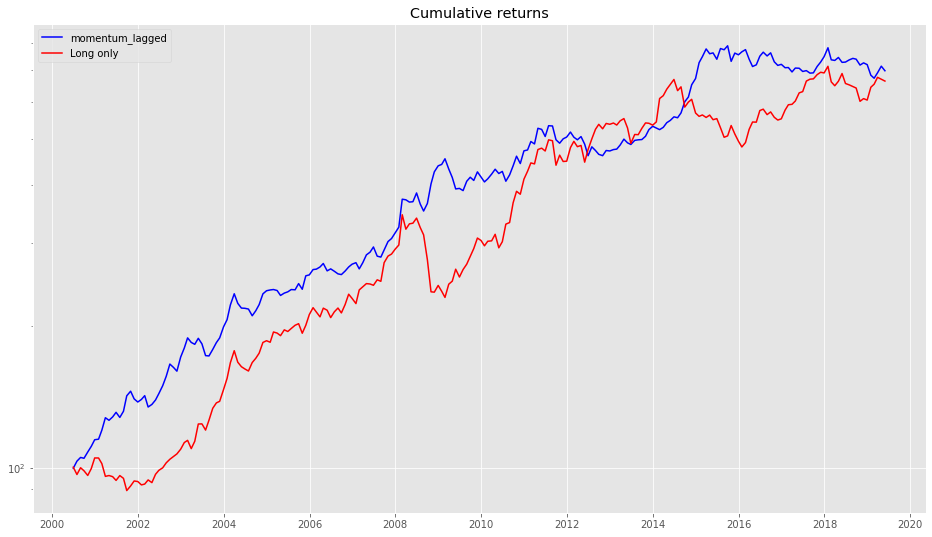

Passive Long only return: 563.65%, Annualized: 10.47%
TSMOM momentum_lagged return: 598.05%, Annualized: 10.77%
Sharpe ratio Model:  0.9748458179019419
Sharpe ratio Long Only:  0.7894018271213199
Beta:  0.005346797411486292
Tempo: 7.8609278202056885 segundos


In [29]:
r_mom, rp_mom = backtesting(parameters, vol="ewma", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

## Momentum composto e Parkinson 

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


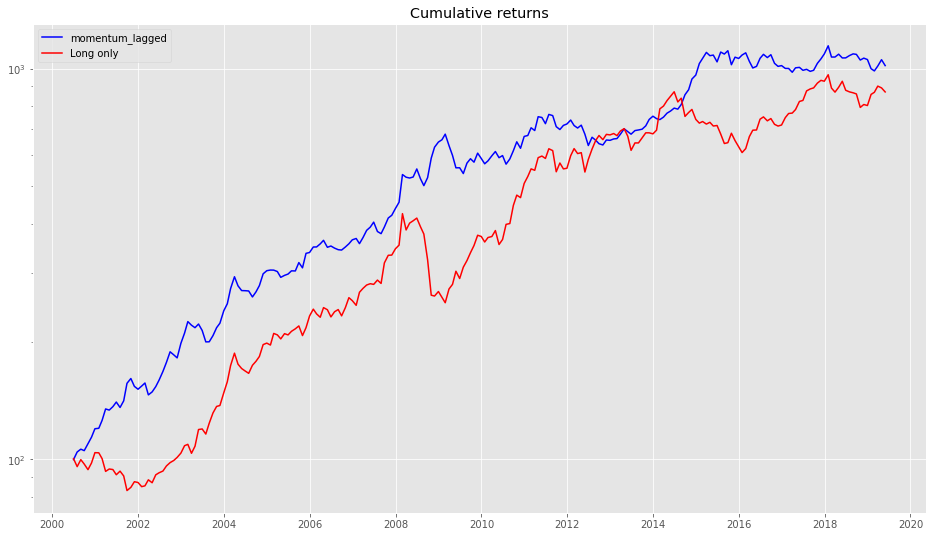

Passive Long only return: 771.56%, Annualized: 12.07%
TSMOM momentum_lagged return: 918.1%, Annualized: 12.99%
Sharpe ratio Model:  0.9951401528271197
Sharpe ratio Long Only:  0.7763354358909687
Beta:  0.0063684919137540034
Tempo: 7.327611684799194 segundos


In [30]:
r_mom_pk, rp_mom_pk = backtesting(parameters, vol="parkinson", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

## Momentum composto e Garman Klass

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


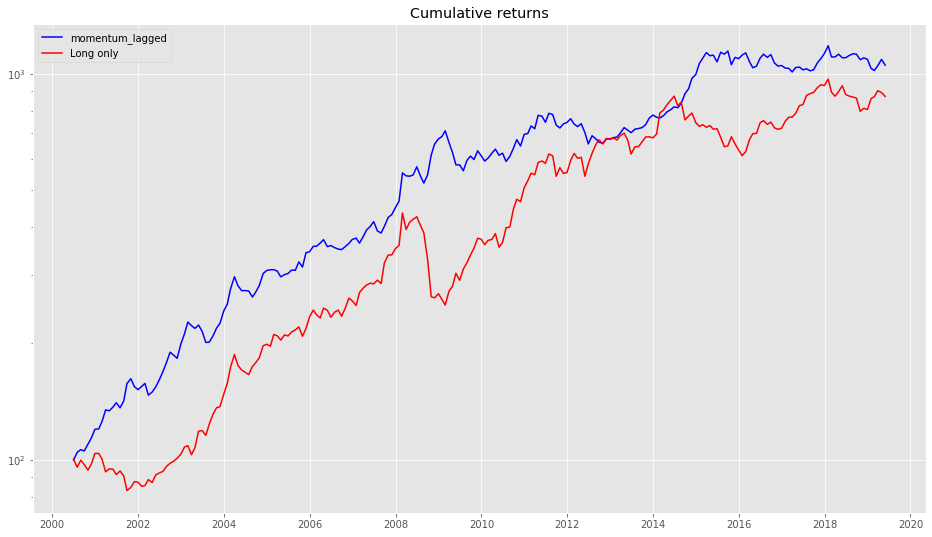

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum_lagged return: 951.62%, Annualized: 13.18%
Sharpe ratio Model:  1.002972466006768
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.0062369984878071745
Tempo: 7.569063901901245 segundos


In [31]:
r_mom_gk, rp_mom_gk = backtesting(parameters, vol="garman_klass", start_date= 12, years=19, risk=0.4, method="momentum_lagged", plot=True);

Com o intuito de adicionar mais informações no modelo, utilizamos o estimador de risco Garman-Klass e construímos um momentum modificado. Que é basicamente a média de momentums com períodos diferentes, os escolhidos foram 3, 6 e 12 meses. Essas modificações fizeram nosso algoritmo performar melhor que o Long Only, tal feito pode ser justificado pela a adição de informações mais recentes ao modelo, fazendo-o reagir mais rapidamente a grandes variações de preço. Com essas modificações alcançamos o resultado de 951,62%! Que anualizado implica em 13,18%.

 |█████████████████████████████████████████-----------------------------------------------------------| 41.4% 

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


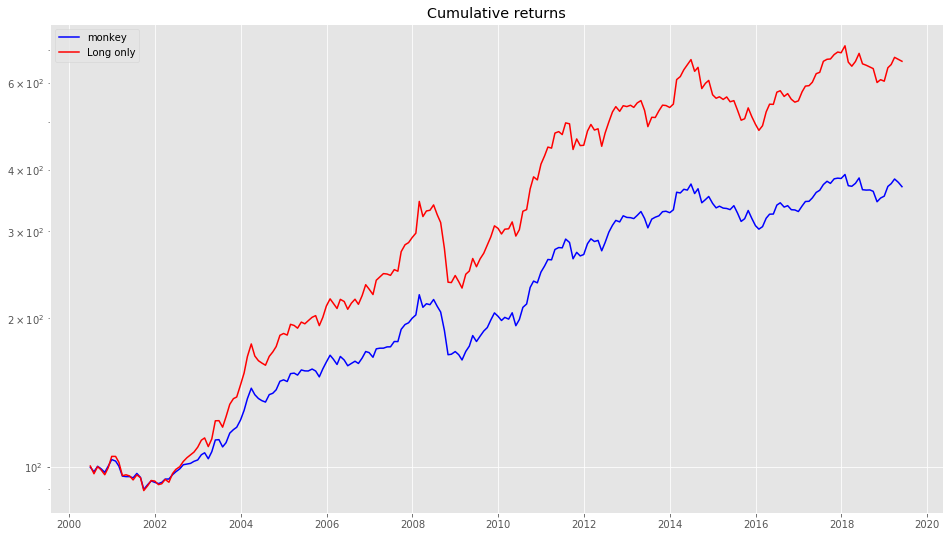

Passive Long only return: 563.65%, Annualized: 10.47%
TSMOM monkey return: 269.52%, Annualized: 7.12%
Sharpe ratio Model:  0.7430682271013413
Sharpe ratio Long Only:  0.7894018271213199
Beta:  0.027878638945478817
Tempo: 0.8345999717712402 segundos


In [32]:
r_monkey, rp_monkey = backtesting(parameters, vol="ewma", start_date= 12, years=19, risk=0.4, method="monkey", plot=True);

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


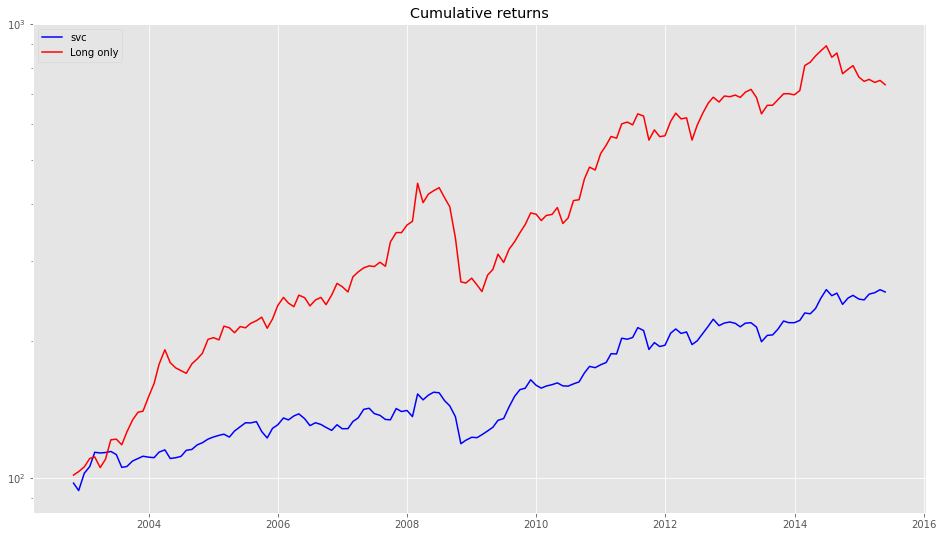

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM svc return: 156.37%, Annualized: 7.51%
Sharpe ratio Model:  0.7143692506196533
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.02371529447274548
Tempo: 1438.8184978961945 segundos


In [33]:
r_svc, rp_svc = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.4, method="svc", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


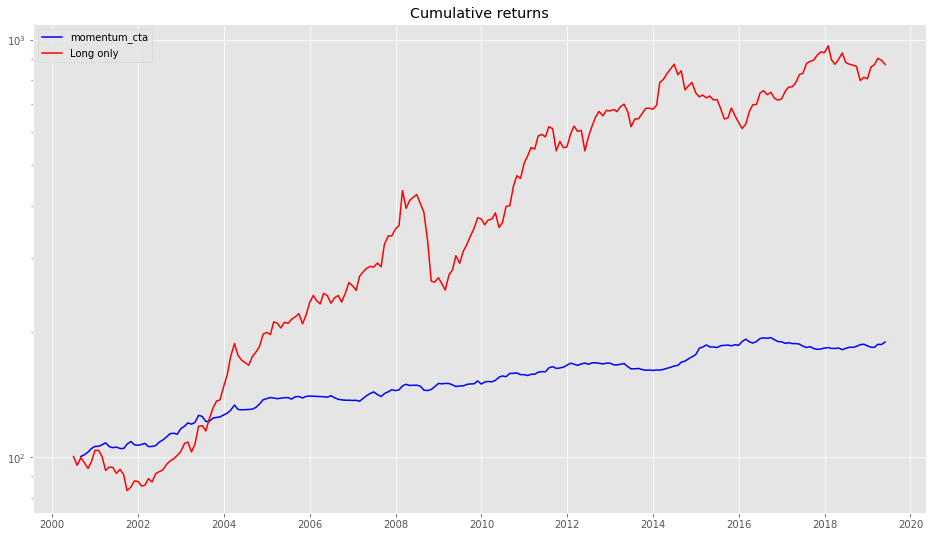

Passive Long only return: 772.49%, Annualized: 12.08%
TSMOM momentum_cta return: 88.8%, Annualized: 3.4%
Sharpe ratio Model:  0.9724371646992064
Sharpe ratio Long Only:  0.7712503553592394
Beta:  0.0014515805484460627
Tempo: 2006.4288051128387 segundos


In [34]:
r_cta, rp_cta = backtesting(parameters, vol="garman_klass", start_date = 12, years=19, risk=0.4, method="momentum_cta", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


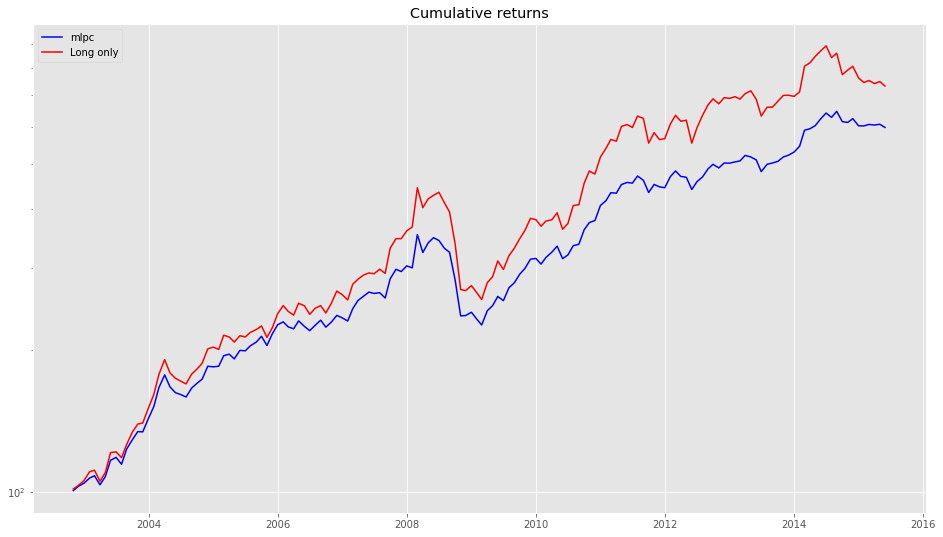

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM mlpc return: 498.36%, Annualized: 14.75%
Sharpe ratio Model:  1.077135991903228
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.039095490922791507
Tempo: 1445.099669933319 segundos


In [35]:
r_mlpc, rp_mlpc = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.4, method="mlpc", plot=True);


 |████████████████████████████████████████████████████████████████████████████████████████████████████| 100.0% 


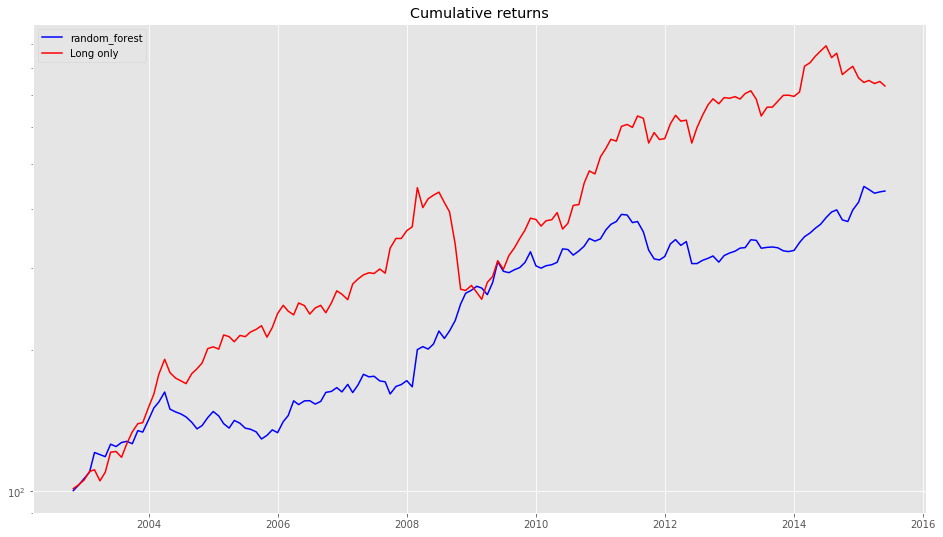

Passive Long only return: 633.41%, Annualized: 16.56%
TSMOM random_forest return: 337.5%, Annualized: 12.02%
Sharpe ratio Model:  0.9482004303039369
Sharpe ratio Long Only:  0.9564663673086711
Beta:  0.009541236606062943
Tempo: 2441.2534914016724 segundos


In [37]:
r_rf, rp_rf = backtesting(parameters, vol="garman_klass", start_date= 40, years=13, risk=0.6, method="random_forest", plot=True);
